In [1]:
import pandas as pd
data=pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\SolcastData\Data17years.csv")
# Assuming your dataset is loaded into a DataFrame called 'data'
# Convert the 'period_end' column to datetime type
data['period_end'] = pd.to_datetime(data['period_end'])

# Filter data to keep only rows between 6 AM and 6 PM
filtered_data = data[(data['period_end'].dt.hour >= 6) & (data['period_end'].dt.hour < 18)]




In [2]:
filtered_data.head()

,air_temp,clearsky_dhi,clearsky_dni,clearsky_ghi,clearsky_gti,cloud_opacity,dewpoint_temp,dhi,dni,ghi,gti,precipitation_rate,relative_humidity,period_end,period
71,12,0,0,0,0,0.0,8.3,0,0,0,0,0.0,78.0,2007-01-01 06:00:00+04:00,PT5M
72,12,0,0,0,0,0.0,8.3,0,0,0,0,0.0,78.1,2007-01-01 06:05:00+04:00,PT5M
73,12,1,0,1,1,0.0,8.3,1,0,1,1,0.0,78.0,2007-01-01 06:10:00+04:00,PT5M
74,12,7,0,7,7,0.0,8.3,7,0,7,7,0.0,77.9,2007-01-01 06:15:00+04:00,PT5M
75,12,14,2,14,14,1.2,8.3,14,0,14,14,0.0,77.8,2007-01-01 06:20:00+04:00,PT5M


In [3]:
filtered_data.to_csv('Data17_Filtered.csv')

In [9]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\SolcastData\Data17_Filtered.csv")

# Retain the 'period_end' column (or 'period') for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (you can drop 'period' but retain 'period_end')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
X_data = data.drop(columns=[target_column, 'period_end'])
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Create sequences and labels for LSTM
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 24  # Number of 5-min intervals (e.g., for 2 hours ahead)
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust the timestamps for the sequences (remove the first 'sequence_length' entries)
timestamps = timestamps[sequence_length:]

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))  # Output layer for 'gti' prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)

model.save('solar_model_17.h5')
model.save_weights('solar_model_17.weights.h5')


c:\Users\Sasi Kanth\anaconda3\envs\rengoku\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 186s 18ms/step - loss: 0.0031 - val_loss: 5.8544e-04
Epoch 2/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 225s 22ms/step - loss: 8.3080e-04 - val_loss: 4.8413e-04
Epoch 3/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 263s 26ms/step - loss: 7.6954e-04 - val_loss: 6.5789e-04
Epoch 4/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 268s 26ms/step - loss: 7.4545e-04 - val_loss: 5.4767e-04
Epoch 5/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 256s 25ms/step - loss: 7.3110e-04 - val_loss: 6.4991e-04
Epoch 6/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 271s 27ms/step - loss: 7.1720e-04 - val_loss: 7.5361e-04
Epoch 7/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 266s 26ms/step - loss: 7.1229e-04 - val_loss: 7.0815e-04
Epoch 8/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 201s 20ms/step - loss: 6.9939e-04 - val_loss: 5.9338e-04
Epoch 9/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 149s 15ms/step - loss: 6.9352e-04 - val_loss: 5.2318e-04
Epoch 10/20
10172/10172 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 6.8312e-04 - val_loss: 5.63

In [17]:
# Inverse transform the predictions and actual values to get the original scale
predictions = scaler_y.inverse_transform(predictions)
actual_values = scaler_y.inverse_transform(y_test)

# Calculate absolute errors
errors = np.abs(predictions - actual_values)

# Find the indices of the max and min errors
max_error_idx = np.argmax(errors)
min_error_idx = np.argmin(errors)

# Retrieve max and min errors and their corresponding predicted, actual values, and timestamps
max_error = errors[max_error_idx]
min_error = errors[min_error_idx]

max_error_predicted = predictions[max_error_idx][0]
max_error_actual = actual_values[max_error_idx][0]
max_error_time = timestamps_test[max_error_idx]

min_error_predicted = predictions[min_error_idx][0]
min_error_actual = actual_values[min_error_idx][0]
min_error_time = timestamps_test[min_error_idx]

# Print the results
print(f"Maximum Error: {max_error}")
print(f"Predicted Value (Max Error): {max_error_predicted}, Actual Value (Max Error): {max_error_actual}")
print(f"Timestamp (Max Error): {max_error_time}")

print(f"Minimum Error: {min_error}")
print(f"Predicted Value (Min Error): {min_error_predicted}, Actual Value (Min Error): {min_error_actual}")
print(f"Timestamp (Min Error): {min_error_time}")

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")

Maximum Error: [921.32386398]
Predicted Value (Max Error): 9.676136016845703, Actual Value (Max Error): 931.0
Timestamp (Max Error): 2022-11-06 11:40:00+04:00
Minimum Error: [1.14440918e-05]
Predicted Value (Min Error): 63.0000114440918, Actual Value (Min Error): 63.0
Timestamp (Min Error): 2021-03-29 16:45:00+04:00
8719/8719 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 1.8310e-04
Test MSE: 0.0005010177846997976


In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming `scalerx` is used for feature scaling and `scalery` is used for target scaling
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions using scalery
predictions = scaler_y.inverse_transform(predictions)

# Inverse transform the actual values (y_test) using scalery
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse, predictions)
print(f"Mean Absolute Error: {mae}")




8719/8719 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step
Mean Absolute Error: 11.437955590891258


In [19]:
from sklearn.metrics import r2_score

# Calculate R² Score
r2 = r2_score(scaler_y.inverse_transform(y_test.reshape(-1, 1)), predictions)
print(f"Test R² Score: {r2}")


Test R² Score: 0.9938447089469051


In [20]:
# Inverse transform the true test labels (y_test) to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Avoid division by zero by filtering out zero values in the actual test set
non_zero_indices = y_test_original != 0

# Calculate the errors (difference between actual and predicted values) for non-zero actual values
errors_percentage = np.abs((y_test_original[non_zero_indices] - predictions[non_zero_indices]) / y_test_original[non_zero_indices]) * 100

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(errors_percentage)

print(f"Total Error Percentage (MAPE): {mape:.2f}%")


Total Error Percentage (MAPE): 7.01%


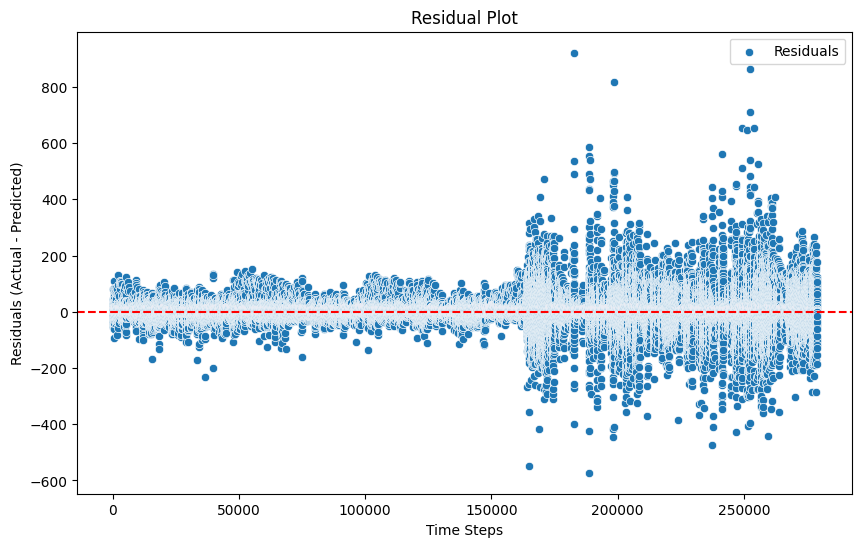

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate residuals
residuals = scaler_y.inverse_transform(y_test.reshape(-1, 1)) - predictions

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(residuals)), y=residuals.flatten(), label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time Steps')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()


In [22]:
# Convert predictions, actual values, and timestamps to a DataFrame
results_df = pd.DataFrame({
    'Timestamp': timestamps_test,  # Test timestamps
    'Actual gti': actual_values.flatten(),  # Flattening the array to a single dimension
    'Predicted gti': predictions.flatten()  # Flattening the array to a single dimension
})

# Save the DataFrame to an Excel file
results_df.to_excel(r'C:\Users\Sasi Kanth\Desktop\SolarPower\Predictions_Filtered.xlsx', index=False)

print("Results saved to Predictions.xlsx")


Results saved to Predictions.xlsx


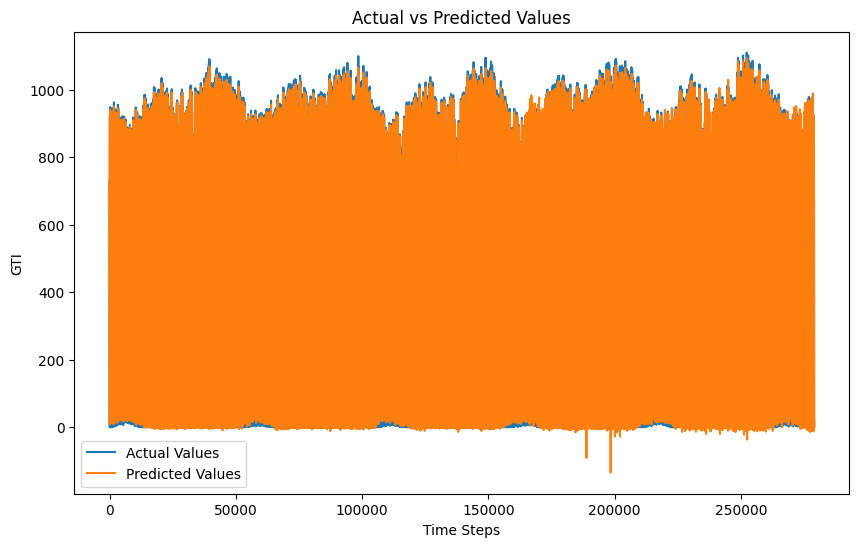

In [23]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('GTI')
plt.legend()
plt.show()


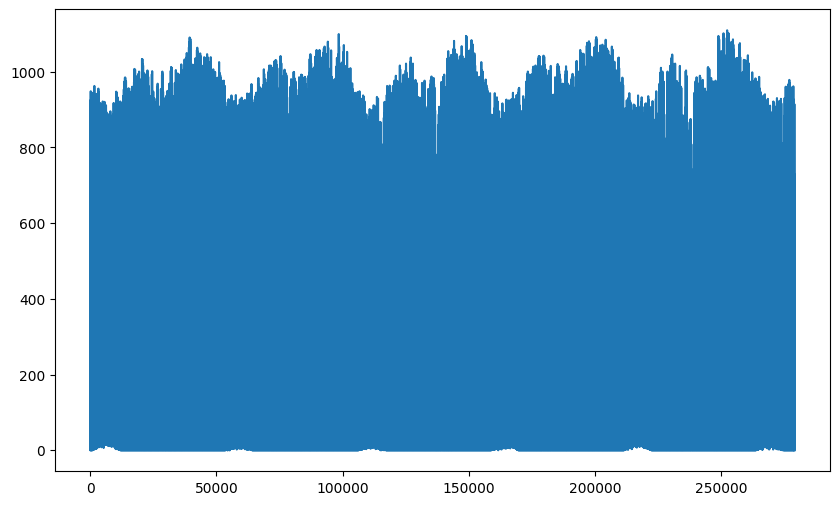

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(scaler_y.inverse_transform(y_test.reshape(-1, 1)), label='Actual Values')
# plt.plot(predictions, label='Predicted Values')

In [60]:
predictions

array([[727.3165   ],
       [712.6228   ],
       [698.05237  ],
       ...,
       [  1.4124428],
       [  6.219448 ],
       [ 15.068222 ]], dtype=float32)

In [56]:
X_test.shape, y_test.shape,predictions.shape

((278979, 24, 13), (278979, 1), (278979, 1))

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load your dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\SolcastData\Data17_Filtered.csv")

# Retain the 'period_end' column for tracking timestamps
timestamps = data['period_end'].values

# Drop unnecessary columns (keep 'period_end', drop 'period')
data = data.drop(columns=['period'])

# Separate the target column 'gti' and features
target_column = 'gti'
X_data = data.drop(columns=[target_column, 'period_end'])
y_data = data[target_column]

# Feature scaling for features and target
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(X, y, sequence_length):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

sequence_length = 24  # Assuming 2 hours (24 * 5-minute intervals)
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Adjust timestamps to remove first 'sequence_length' entries
timestamps = timestamps[sequence_length:]

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X_data.shape[1]))

# Split into training and testing datasets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Also split the timestamps to align with test data
timestamps_train, timestamps_test = timestamps[:split], timestamps[split:]

# Load your saved model
model = load_model('solar_model_17.h5')

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions_original_scale = scaler_y.inverse_transform(predictions)

# Inverse transform the true y_test values to their original scale
y_test_original_scale = scaler_y.inverse_transform(y_test)

# Extract the corresponding part of the original dataset for the test split
original_test_data = data.iloc[split + sequence_length:].copy()

# Add the predictions to the original test dataset
original_test_data['predicted_gti'] = predictions_original_scale

# Optionally, add the true values for comparison
original_test_data['true_gti'] = y_test_original_scale

# Save the dataset with the predictions
output_path = r"C:\Users\Sasi Kanth\Desktop\SolarPower\TestDatasetWithPredictions.csv"
original_test_data.to_csv(output_path, index=False)

print(f"Test dataset with predictions saved to: {output_path}")


8719/8719 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
Test dataset with predictions saved to: C:\Users\Sasi Kanth\Desktop\SolarPower\TestDatasetWithPredictions.csv


In [5]:
# Calculate the absolute error between actual and predicted values
original_test_data['error'] = np.abs(original_test_data['true_gti'] - original_test_data['predicted_gti'])

# Sort by the highest errors
high_error_cases = original_test_data.sort_values(by='error', ascending=False).head(5)

# Display the high error cases with original columns
print(high_error_cases[['period_end', 'true_gti', 'predicted_gti', 'error'] + list(X_data.columns)])


                       period_end  true_gti  predicted_gti       error  \
833540  2022-11-06 11:40:00+04:00     931.0       9.676136  921.323864   
903401  2024-03-05 13:25:00+04:00     828.0     -36.606743  864.606743   
849366  2023-02-24 10:30:00+04:00     683.0    -135.016739  818.016739   
903521  2024-03-06 11:25:00+04:00     925.0     215.326813  709.673187   
905089  2024-03-17 10:05:00+04:00    1005.0     352.357758  652.642242   

        Unnamed: 0  air_temp  clearsky_dhi  clearsky_dni  clearsky_ghi  \
833540     1667083        33           213           723           740   
903401     1806784        24           209           754           758   
849366     1698749        28           234           743           808   
903521     1807048        24           213           806           894   
905089     1810200        30           196           838           889   

        clearsky_gti  cloud_opacity  dewpoint_temp  dhi  dni  ghi  \
833540           931            0.0      

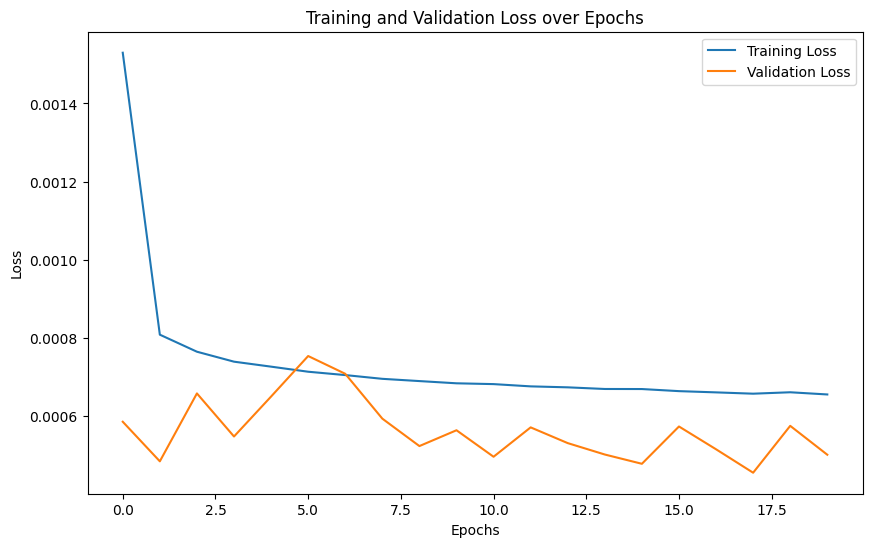

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.show()


In [16]:
import pandas as pd

# Load the dataset
data = pd.read_csv(r"C:\Users\Sasi Kanth\Desktop\SolarPower\TestDatasetWithPredictions.csv")

# Parse the 'datetime' column to ensure proper time manipulation
data['period_end'] = pd.to_datetime(data['period_end'])

# Set the window parameters
window_size = '2H'  # 2 hours
step_size = '1H'    # 1 hour

# Initialize lists to store results
timestamps = []
avg_actual_gti = []
avg_predicted_gti = []

# Iterate over the dataset in 1-hour sliding windows
start_time = data['period_end'].min()

while start_time + pd.Timedelta(window_size) <= data['period_end'].max():
    # Define the time window
    end_time = start_time + pd.Timedelta(window_size)
    
    # Filter the data within the current window
    window_data = data[(data['period_end'] >= start_time) & (data['period_end'] < end_time)]
    
    # Calculate the averages for actual and predicted GTI
    avg_actual = window_data['true_gti'].mean()
    avg_predicted = window_data['predicted_gti'].mean()
    
    # Append results
    timestamps.append(start_time)
    avg_actual_gti.append(avg_actual)
    avg_predicted_gti.append(avg_predicted)
    
    # Move the window by 1 hour
    start_time += pd.Timedelta(step_size)

# Create a new DataFrame with the results
result_df = pd.DataFrame({
    'datetime': timestamps,
    'avg_actual_gti': avg_actual_gti,
    'avg_predicted_gti': avg_predicted_gti
})

# Save the result to a new CSV file
output_path = "average_gti_windowed.csv"
result_df.to_csv(output_path, index=False)

print(f"File saved to {output_path}")


File saved to average_gti_windowed.csv


In [21]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("TestDatasetWithPredictions.csv")

# Convert 'period_end' to datetime and remove any timezone information
df['period_end'] = pd.to_datetime(df['period_end']).dt.tz_localize(None)

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['period_end', 'average_actual_gti', 'average_predicted_gti'])

# Define the window parameters (2-hour averaging with 1-hour sliding window)
window_size = pd.Timedelta(hours=2)
step_size = pd.Timedelta(hours=1)

# Function to calculate window averages for a given day's data
def calculate_daily_windows(daily_data, start_time):
    global result_df
    while start_time + window_size <= daily_data['period_end'].max():
        # Define the end time for the window
        end_time = start_time + window_size

        # Filter the data within this window
        window_data = daily_data[(daily_data['period_end'] >= start_time) & (daily_data['period_end'] < end_time)]

        # Calculate the average actual and predicted GTI values
        avg_actual_gti = window_data['true_gti'].mean()  # Replace with the correct column name
        avg_predicted_gti = window_data['predicted_gti'].mean()  # Replace with the correct column name

        # Create a DataFrame for the current window's averages
        row_df = pd.DataFrame({
            'period_end': [start_time],
            'average_actual_gti': [avg_actual_gti],
            'average_predicted_gti': [avg_predicted_gti]
        })

        # Concatenate the new row to the result DataFrame
        result_df = pd.concat([result_df, row_df], ignore_index=True)

        # Move the window forward by 1 hour
        start_time += step_size

# Process the first day's data starting from the first available time
first_day = df['period_end'].dt.date.min()
first_day_data = df[df['period_end'].dt.date == first_day]

# Get the first row's time as the starting point
start_time = first_day_data['period_end'].min()

# Calculate windows for the first day
calculate_daily_windows(first_day_data, start_time)

# Process each subsequent day, starting from 6 AM
for date in pd.date_range(start=first_day + pd.Timedelta(days=1), end=df['period_end'].dt.date.max(), freq='D'):
    # Get the data for the current day
    daily_data = df[df['period_end'].dt.date == date.date()]
    
    if daily_data.empty:
        continue  # Skip if no data for that day

    # Define the starting time for the day (6 AM)
    start_time = pd.Timestamp(date.date()) + pd.Timedelta(hours=6)

    # Only include data between 6 AM and 6 PM
    daily_data = daily_data[(daily_data['period_end'].dt.hour >= 6) & (daily_data['period_end'].dt.hour <= 18)]
    
    # Calculate windows for this day
    calculate_daily_windows(daily_data, start_time)

# Save the result to a CSV file
output_path = "GTI_Averages_Adjusted_Final.csv"
result_df.to_csv(output_path, index=False)

output_path


C:\Users\Sasi Kanth\AppData\Local\Temp\ipykernel_20656\2804403842.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, row_df], ignore_index=True)


'GTI_Averages_Adjusted_Final.csv'

In [22]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("TestDatasetWithPredictions.csv")

# Convert 'period_end' to datetime and remove any timezone information
df['period_end'] = pd.to_datetime(df['period_end']).dt.tz_localize(None)

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['period_end', 'average_actual_gti', 'average_predicted_gti'])

# Define the window parameters (2-hour averaging with 1-hour sliding window)
window_size = pd.Timedelta(hours=2)
step_size = pd.Timedelta(hours=1)

# Function to calculate window averages for a given day's data
def calculate_daily_windows(daily_data, start_time):
    global result_df
    while start_time + window_size <= daily_data['period_end'].max():
        # Define the end time for the window
        end_time = start_time + window_size

        # Filter the data within this window
        window_data = daily_data[(daily_data['period_end'] >= start_time) & (daily_data['period_end'] < end_time)]

        # Calculate the average actual and predicted GTI values
        avg_actual_gti = window_data['true_gti'].mean()  # Replace with the correct column name
        avg_predicted_gti = window_data['predicted_gti'].mean()  # Replace with the correct column name

        # Create a DataFrame for the current window's averages
        row_df = pd.DataFrame({
            'period_end': [start_time],
            'average_actual_gti': [avg_actual_gti],
            'average_predicted_gti': [avg_predicted_gti]
        })

        # Concatenate the new row to the result DataFrame
        result_df = pd.concat([result_df, row_df], ignore_index=True)

        # Move the window forward by 1 hour
        start_time += step_size

# Process the first day's data starting from the first available time
first_day = df['period_end'].dt.date.min()
first_day_data = df[df['period_end'].dt.date == first_day]

# Get the first row's time as the starting point
start_time = pd.Timestamp(first_day) + pd.Timedelta(hours=6, minutes=5)  # 6:05 AM

# Calculate windows for the first day
calculate_daily_windows(first_day_data, start_time)

# Process each subsequent day, starting from 6:05 AM
for date in pd.date_range(start=first_day + pd.Timedelta(days=1), end=df['period_end'].dt.date.max(), freq='D'):
    # Get the data for the current day
    daily_data = df[df['period_end'].dt.date == date.date()]
    
    if daily_data.empty:
        continue  # Skip if no data for that day

    # Define the starting time for the day (6:05 AM)
    start_time = pd.Timestamp(date.date()) + pd.Timedelta(hours=6, minutes=5)

    # Only include data between 6:05 AM and 5:55 PM
    daily_data = daily_data[(daily_data['period_end'].dt.time >= pd.to_datetime("06:05").time()) &
                            (daily_data['period_end'].dt.time <= pd.to_datetime("17:55").time())]
    
    # Calculate windows for this day
    calculate_daily_windows(daily_data, start_time)

# Save the result to a CSV file
output_path = "GTI_Averages_Adjusted_Final_0.csv"
result_df.to_csv(output_path, index=False)

output_path


C:\Users\Sasi Kanth\AppData\Local\Temp\ipykernel_20656\256519264.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, row_df], ignore_index=True)


'GTI_Averages_Adjusted_Final_0.csv'